In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from scipy.sparse.linalg import norm
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime as datetime
from sklearn.manifold import TSNE
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation

### Create dictionary from (user, year) tuple to the class

In [2]:
user_year_to_class = {}
min_year = 2005
with open("yelp_academic_dataset_user.json") as f:
    for l in f:
        line = json.loads(l)
        user = line["user_id"]
        
        elites = line["elite"]
        if "None" not in elites:
            for yr in elites:
                yr_int = int(yr)
                if yr_int - 1 >= min_year and str(yr_int - 1) not in elites:
                    user_year_to_class[(user, yr_int - 1)] = 2
                if str(yr_int + 1) in elites:
                    user_year_to_class[(user, yr_int)] = 1
                else:
                    user_year_to_class[(user, yr_int)] = 3

In [5]:
print user_year_to_class.items()[:10]

[((u'FBQ8aB_55GqvtaROAzU4Ww', 2008), 2), ((u'blrWvPePSv87aU9hV1Zd8Q', 2010), 2), ((u'XL1IkA7cKNOUFccndX2i_w', 2009), 1), ((u'ifZJeZuTTj4dfEoR29I6bA', 2011), 1), ((u'41HLwXnR0Lm3NUp01cIOQg', 2012), 1), ((u'ITf8PiWzmTzcZu3kRWEoGg', 2014), 2), ((u'-hKniZN2OdshWLHYuj21jQ', 2017), 3), ((u'd2ZZr4-jMlK0CWFOyALGNg', 2010), 3), ((u'lHGI9cubh0g4wG0LFt1rdA', 2016), 3), ((u'vJGJSKj3DRIPpQqqz_9gnQ', 2014), 2)]


In [6]:
# return class given user and year
def user_class(user, year):
    if (user, year) in user_year_to_class:
        return user_year_to_class[(user, year)]
    else:
        return 0

In [7]:
# get list of reviews, texts, and classes
reviews = []
texts = []
classes = []
with open("yelp_academic_dataset_review.json") as f:
    for l in f:
        if len(reviews) > 10000:
            break
        line = json.loads(l)
        reviews.append(line)
        texts.append(line["text"])
        
        date = datetime.datetime.strptime(line['date'], '%Y-%m-%d')
        year = int(date.strftime('%Y'))
    
        user = line["user_id"]
        clss = user_class(user, year)
        classes.append(clss)

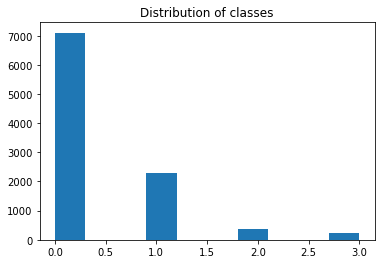

In [8]:
plt.hist(classes)
plt.title("Distribution of classes")
plt.show()

### Create and fit a TF-IDF representation of the reviews

In [9]:
tfidf = TfidfVectorizer(norm=None)
trans = tfidf.fit_transform(texts)

### Plot singular values to see how many dimensions are actually relevant

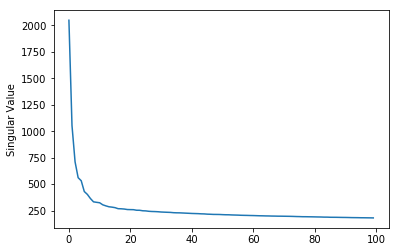

In [10]:
test_kval = 100

s= svds(trans, k=test_kval, return_singular_vectors=False)
plt.plot(range(test_kval), sorted(s, reverse=True))
plt.ylabel("Singular Value")
plt.show()

In [11]:
chosen_kval = 20 #decided on 20 based on the graph
u, s, v = svds(trans, k=chosen_kval)

model = TSNE(n_components=2)
reduced = model.fit_transform(u)

### Plot T-SNE output for all of the reduced reviews- just maps the data to two dimensions for visualization purposes

In [13]:
cmap = {0:"red", 1:"green", 2:"black", 3:"blue"}

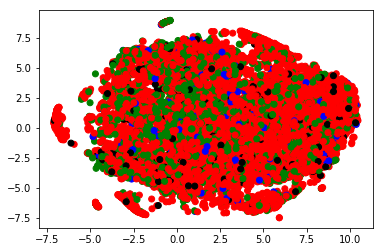

In [10]:
colors = [cmap[cls] for cls in classes]
plt.scatter(reduced[:, 0], reduced[:, 1], c=colors)
plt.show()

### Plot T-SNE output for only classes 1-3 (exluding the class that was never elite), we see that there isn't much clustering...

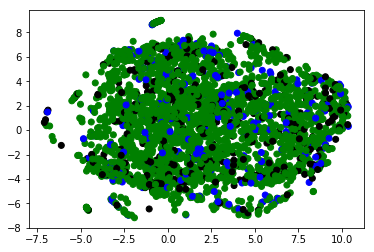

In [11]:
non_zero = []
non_zero_classes = []
for ind, cls in enumerate(classes):
    if cls != 0:
        non_zero.append(reduced[ind])
        non_zero_classes.append(cls)
colors = [cmap[cls] for cls in non_zero_classes]
plt.scatter(np.array(non_zero)[:, 0], np.array(non_zero)[:, 1], c=colors)
plt.show()

### Plot in 3d to see if there are any differences

In [12]:
chosen_kval = 20
u, s, v = svds(trans, k=chosen_kval)

model = TSNE(n_components=3)
reduced = model.fit_transform(u)

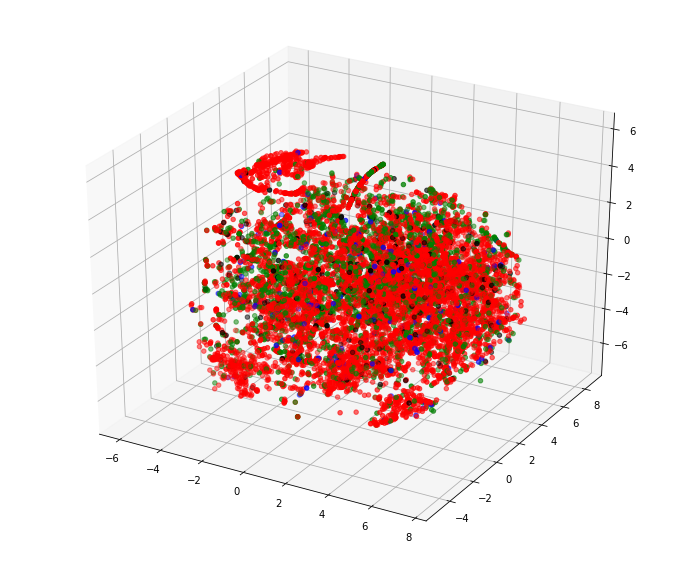

In [13]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = [cmap[cls] for cls in classes]
ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=colors)
plt.show()

### Look into differences in the tf-idf lengths and non-zero features(aka unique words used)

In [25]:
# get review norm for each class, and average over them
class_norms = {}
for ind, row in enumerate(trans):
    if classes[ind] not in class_norms:
        class_norms[classes[ind]] = [norm(row)]
    else:
        class_norms[classes[ind]].append(norm(row))
for cls, norms in class_norms.items():
    print "Class {}, Mean tf-idf review length: {}".format(cls, np.mean(norms))

Class 0, Mean tf-idf review length: 48.7535498133
Class 1, Mean tf-idf review length: 59.9813739801
Class 2, Mean tf-idf review length: 53.2583999647
Class 3, Mean tf-idf review length: 54.801801752


In [26]:
#for each class, get the average number of non-zero features
class_features = {}
for ind, row in enumerate(trans):
    if classes[ind] not in class_features:
        class_features[classes[ind]] = [len(row.data)]
    else:
        class_features[classes[ind]].append(len(row.data))
for cls, feats in class_features.items():
    print "Class {}, Mean number of non-zero features: {}".format(cls, np.mean(feats))

Class 0, Mean number of non-zero features: 71.599042658
Class 1, Mean number of non-zero features: 96.9514310494
Class 2, Mean number of non-zero features: 85.7845303867
Class 3, Mean number of non-zero features: 85.5304347826


### Look at the largest differences (by tf-idf weights) between words used in the 4 different classes

In [35]:
stemmer = PorterStemmer()
def tokenize(text):
    tokens = word_tokenize(text)
    stems = [stemmer.stem(token) for token in tokens]
    return stems

#need to normalize the tfidf
norm_tfidf = TfidfVectorizer(stop_words="english", min_df=5, max_df=0.8, ngram_range=(1,2))
norm_trans = norm_tfidf.fit_transform(texts)
features = norm_tfidf.get_feature_names()

In [36]:
class_counts = {}
for ind, row in enumerate(norm_trans):
    cls = classes[ind]
    if cls not in class_counts:
        class_counts[cls] = [row.toarray()[0], 1]
    else:
        class_counts[cls][0] += row.toarray()[0]
        class_counts[cls][1] += 1
class_avg = {cls: counts[0]/counts[1] for (cls, counts) in class_counts.items()}

for cls, avg in class_avg.items():
    for cls2, avg2 in class_avg.items():
        if cls < cls2:
            similarities = []
            for i in range(len(avg)):
                similarities.append((i, avg[i]-avg2[i]))
            print "\nClass {} - Class {}".format(cls, cls2)
            for feature, diff in sorted(similarities, key=lambda x:abs(x[1]), reverse=True)[:5]:
                print "{}: {}".format(features[feature], diff)


Class 0 - Class 1
und: 0.00924304913366
die: 0.00667291344336
really: -0.00655012391387
like: -0.00609911947923
little: -0.00593350610874

Class 0 - Class 2
good: -0.00812166957085
place: -0.00769880496466
und: 0.00663834204296
really: -0.00662715213679
like: -0.00630205402659

Class 0 - Class 3
great: 0.00863323526749
like: -0.00822137873205
really: -0.00819471406961
und: 0.00818974445303
pretty: -0.00786875114705

Class 1 - Class 2
place: -0.00526828233355
great: -0.0050095467268
food: -0.00482244740132
good: -0.00473012902105
dance: -0.00469943997679

Class 1 - Class 3
coffee: 0.00578280457159
salon: -0.0057524076686
fine: -0.0052564872711
probably: -0.0051817528008
good: 0.00514270723345

Class 2 - Class 3
good: 0.0098728362545
great: 0.00938091869179
pizza: -0.00785058350012
decent: 0.00643033616663
coffee: 0.00615936195015


### Try different set of class 0, also get topic modeling working

look at cluster for single year of elite-> nonelite and nonelite->elite

find a "relevance" metric

readability

In [5]:
reviews = []
texts = []
classes = []
with open("yelp_academic_dataset_review.json") as f:
    for l in f:
        line = json.loads(l)
        
        date = datetime.datetime.strptime(line['date'], '%Y-%m-%d')
        year = int(date.strftime('%Y'))
    
        user = line["user_id"]
        clss = user_class(user, year)
        if (clss == 2 or clss == 3) and year == 2010:
            classes.append(clss)
            reviews.append(line)
            texts.append(line["text"])

In [6]:
print len(texts), len(classes)

14581 14581


In [7]:
filt_tfidf = TfidfVectorizer(norm=None)
filt_trans = filt_tfidf.fit_transform(texts)

In [10]:
u, s, v = svds(filt_trans, k=20)
print u.shape

(14581L, 20L)


In [11]:
model = TSNE(n_components=3)
reduced = model.fit_transform(u)

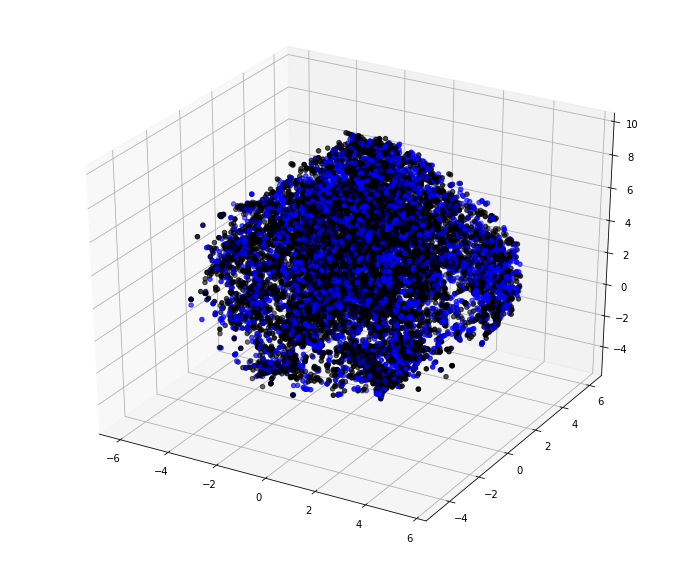

In [16]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = [cmap[cls] for cls in classes]
ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=colors)
plt.show()

### Try topic modeling

In [11]:
reviews = []
texts = []
classes = []
with open("yelp_academic_dataset_review.json") as f:
    for l in f:
        if len(reviews) > 100000:
            break
        line = json.loads(l)
        reviews.append(line)
        texts.append(line["text"])
        
        date = datetime.datetime.strptime(line['date'], '%Y-%m-%d')
        year = int(date.strftime('%Y'))
    
        user = line["user_id"]
        clss = user_class(user, year)
        classes.append(clss)

In [12]:
topic_tfidf = TfidfVectorizer(stop_words="english", min_df=5)
topic_trans = topic_tfidf.fit_transform(texts)
features = topic_tfidf.get_feature_names()

In [9]:
def display_topics(model, feature_names, n_top_words):
    for topic_index, topic in enumerate(model.components_):
        print("Topic %d:" % topic_index)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))

In [13]:
lda_model = LatentDirichletAllocation(n_topics=15).fit(topic_trans)
display_topics(lda_model, features, 20)

C:\Users\jtlia\Anaconda2\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic 0:
food good place chicken restaurant menu fresh great ordered delicious lunch pizza service like cheese really sauce just order
Topic 1:
liz papa stolen batteries knacks automotive knick fraction johns kits laurent matthews challenges blamed hoa nike cartridge charger grapes
Topic 2:
printing fusion staple print lo exam alike sean updating bedside todd plug lily shawn creations servicing snap dean tailoring
Topic 3:
nails insurance nail manicure dave gel polish scheduling conditioning salesman dan pa matters hygienist explains william urgent medication label
Topic 4:
dr dentist pain broken dental thorough property maintenance office doctors trail wax lashes waxing teeth doctor massage patients fi
Topic 5:
vet yelpers grooming agent estate lv certificate groomer ryan adjustments maki fool realtor attraction educational petsmart bruce availability jerry
Topic 6:
ramen ur pecan keith kenny cabinet charleston guitars tartare backwards letters hardworking denise corsets portraits fil